# Numerical Solution of the growth in time of a longitudinal crack 

Using the data from the paper (Jiang et al., 2017) [Paper 83]

* N = 14	day

* C = 2.2E-12	m/cycle

* dP= Pmax - Pmin = 0.52-0.39 = 0.13	Pa

* m=6.4	

* D=0.5	m

* t=0.015	m

* lcritical = 0.3 m

In [44]:
import matplotlib.pyplot as plt
import math
import pandas as pd
import numpy as np

#universal constants
g=10 #m/s²
ro= 1000 #kg/m³

#criteria for the output
detectableFlow = 0.250 #m3/h

#delta time of one year 
deltaT = 1


In [45]:
fAttributes='Data/CrackModel/00-SensitivityAnalysisParams.csv'

attributes = pd.read_csv(fAttributes, delimiter = ',')
attributes['Dint (m)']= attributes['Dint (mm)']/100
attributes['Thickness (m)']= attributes['Thickness (mm)']/100
attributes['Elastic modulus (Pa)']= attributes['Elastic modulus (Gpa)']*10**9
attributes.set_index('Material',inplace=True)
attributes.rename(columns={'Cparis ((m/c)/(Mpa*sqrt(m))^m)':'Cparis'}, inplace= True)


In [46]:
#density of water and gravity have to be predefined
def getMLongFAVAD(lf,Dint,E,t):
    
    return (2.93157*(Dint**0.3379)*(lf**4.8)*(10**(0.5997*(math.log(lf,10)**2)))*ro*g)/(E*(t**1.746))
           
def convertmToMPa(pressureInm):
    
    return pressureInm * ro * g / (10 ** 6)

def convertMPaTom(pressureInMPa):
    
    return pressureInMPa * (10 ** 6)/(ro * g)


In [47]:
#Uses Pmax for the flow (i.e. minimum night flow)
# Pressures in meters column of water
def createCurveUntilDetectable(widthC,Cd,E,Cparis,Mparis,t,Dint,lo,nCicles,Pmax,Pmin):

    #initialization 
    li = lo
    Timef = 0
    D= Dint
    Q= 0
    critical = False
    curveVals = []
    curveQVals = []
    daysPerIter = 1
    i = 0
    
    #gets the pressure and pressure difference in the necessary units for TADA and FAVAD eq
    deltaP= convertmToMPa(Pmax-Pmin)
    h= Pmax

    #Euler
    while Q < detectableFlow:

        #Paris Law------------------------------------------------------------------
        
        #calculation of the geometric factor (from Tada)
        lam = li/(D*t/2)**0.5
        if lam <= 1:
            Y = (1+1.25* lam**2)**0.5   
        elif lam <= 5:
            Y = 0.6 + (0.9 * lam)
        else:
            critical = True
            break
            
        #calculation of delta K
        deltaK = deltaP * D / (2*t) * Y * (math.pi * li)**0.5

        #Final lenght of the crack
        lf = (Cparis * deltaK**Mparis )* (nCicles*daysPerIter) + li

        
        # FAVAD--- from paper 012---------------------------------------------------
        leakArea = lf*widthC
        
        mFAVAD = getMLongFAVAD(lf,Dint,E,t)
        
        Q = Cd*((2*g)**0.5)*(leakArea*(h**0.5)+mFAVAD*(h**1.5))
        
        curveVals.append([Timef,lf])
        curveQVals.append([Timef,Q])   
        
        li = lf
        Timef += deltaT
       # i+=1
        
        #if i == 1000:
         #   daysPerIter= 3
    
        
    return Timef, critical, curveVals, curveQVals

In [48]:
# Standard Values 
def getCurrentValsDict(widthC,Cd,E,Cparis,mParis,thickness,Dint,cLenght,N,Pmax,Pmin):
    
    currentVals = { "widthC": widthC, #m
                   "Cd": Cd, #dimensionless
                   "E": E, # 
                   "Cparis": Cparis,
                   "mParis": mParis,
                   "thickness": thickness, #m
                   "Dint": Dint, #m
                   "cLenght" : cLenght,
                   "N" : N,
                   "PMax" : Pmax,
                   "PMin" : Pmin
        }
    
    return currentVals



In [49]:
def createBrokenAxisEffect(ax1, ax2):
    
    ax1.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax1.xaxis.tick_top() 

    d = .015  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
    kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
    ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
    ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
    ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

    return ax1, ax2


In [53]:
materials = attributes.index.unique()
labels = ['Very low', 'Low', 'Typical','High', 'Very high']
markers = ['.','*','+','<','d','o','x','s', 'p','P','X']
indexValues = [0,4,1,3,2]


for material in ["PVC"]:
    
    mV= attributes.loc[material].reset_index()
    
    #FAVAD constants (min, typical, max, name)
    widths = [0.0005, 0.001, 0.05, "widthC"]# m  (min from paper 012)
    Cds = [0.5, 0.65, 0.8, "Cd"] #dimensionless (from paper 007)

    EModulus = [mV.loc[0,'Elastic modulus (Pa)'], mV.loc[1,'Elastic modulus (Pa)'], mV.loc[2,'Elastic modulus (Pa)'], "E"] #Pa (from excel material properties)
    CsParis = [mV.loc[0,'Cparis'], mV.loc[1,'Cparis'], mV.loc[2,'Cparis'], "Cparis"] #((m/c)/(MPa*sqrt(m))^m (aprox from equation and Book C001)
    msParis = [mV.loc[0,'mParis'], mV.loc[1,'mParis'], mV.loc[2,'mParis'], "mParis"] # (aprox from equation and Book C001)

    thicks = [mV.loc[0,'Thickness (m)'], mV.loc[1,'Thickness (m)'], mV.loc[2,'Thickness (m)'], "thickness"] #m (from paper 012, 001, 98)
    Dsint = [mV.loc[0,'Dint (m)'], mV.loc[1,'Dint (m)'], mV.loc[2,'Dint (m)'], "Dint"]#m (aprox from data wPipesGISNfailures[['NOM_DIA_MM']])

    crackLenghs= [0.001, 0.050, 0.100, "cLenght"] #m (assumtion)

    Ncycles= [1, 5, 14, "N"] #cycle per day (assumption)
    PressuresMin = [0, 20 , 55, "PMin"] #mca
    PressuresMax = [30, 60 ,100, "PMax"] #mca

    #list of variable variables
    va = [widths,Cds,EModulus,CsParis,msParis,thicks,Dsint,crackLenghs,Ncycles,PressuresMax,PressuresMin]

    #-----------------------------------
    finVals = []
    cVals = getCurrentValsDict(va[0][1],va[1][1],va[2][1],va[3][1],va[4][1],va[5][1],
                               va[6][1],va[7][1],va[8][1],va[9][1],va[10][1])
    
    for v in va:

        vMin, vTypical, vMax, name = v[0], v[1], v[2] ,v[3]

        int1 = vMin + (vTypical - vMin)/2
        int2 = vTypical + (vMax - vTypical)/2

        for val, i in zip([vMin, vMax,int1,int2, vTypical], indexValues):

            cVals[name] = val

            timeDetectable, critical, curveVals, curveQVals = createCurveUntilDetectable(cVals["widthC"],cVals["Cd"],cVals["E"],cVals["Cparis"]
                                                        ,cVals["mParis"],cVals["thickness"],cVals["Dint"],
                                                        cVals["cLenght"],cVals["N"],cVals["PMax"],cVals["PMin"])

            finVals.append([val, name, timeDetectable, critical, labels[i]])



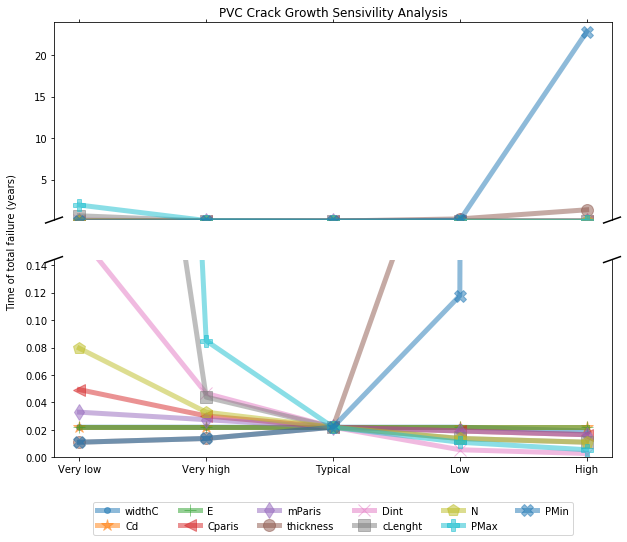

In [24]:
results = pd.DataFrame(finVals, columns=['Value', 'Variable', 'CriticalCycles', 'CriticalLength','Name'])
results['Time (year)'] = results['CriticalCycles']/(365)
results.set_index('Variable',inplace= True)
    
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(10, 8))
outlinLim = np.quantile(results['Time (year)'],0.90)

for var, m in zip(results.index.unique(),markers):

    resVar = results.loc[var].copy()
    resVar.sort_values('Value',inplace=True)

    ax1.plot(resVar['Name'],resVar['Time (year)'],label=var, marker=m,ms=12, linewidth=5, alpha=0.5)
    ax2.plot(resVar['Name'],resVar['Time (year)'],label=var, marker=m,ms=12, linewidth=5, alpha=0.5)


ax1.set_ylim(bottom= outlinLim)
ax2.set_ylim(0,outlinLim)
ax1, ax2= createBrokenAxisEffect(ax1,ax2)

fig.text(0.06, 0.5, 'Time of total failure (years)', va='center', rotation='vertical')
ax1.set_title(material +' Crack Growth Sensivility Analysis')
    #ax2.set_xlabel(getLabelPressure(pressureCriteria))
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=6)


fig.savefig('Maps_Graph/CrackGrowth/'+ material+ 'Sensivility' +'.png', dpi=100,      
                                   bbox_inches='tight')
    

## BREAK -----------------------------------------------

In [54]:
results = pd.DataFrame(finVals, columns=['Value', 'Variable', 'CriticalCycles', 'CriticalLength','Name'])
results.to_csv('Output/ValsPVCSensibility'+ '.csv')


In [105]:
attributes

,Dint (mm),Dext (mm),Thickness (mm),Elastic modulus (Gpa),Cparis,mParis,Dint (m),Thickness (m),Elastic modulus (Pa)
Material,,,,,,,,,
CLCI,80.0,96,8.0,72.00,6.120000e-16,6.200,0.800,0.080,7.200000e+10
CLCI,100.0,122,11.0,100.00,1.300000e-12,6.450,1.000,0.110,1.000000e+11
CLCI,600.0,667,33.5,206.00,2.590000e-12,6.700,6.000,0.335,2.060000e+11
DI,80.0,96,8.0,165.00,3.510000e-19,3.500,0.800,0.080,1.650000e+11
DI,150.0,177,13.5,170.00,7.200000e-12,6.450,1.500,0.135,1.700000e+11
DI,750.0,826,38.0,172.00,1.440000e-11,9.400,7.500,0.380,1.720000e+11
AC,80.0,96,8.0,24.00,NaN,NaN,0.800,0.080,2.400000e+10
AC,100.0,122,11.0,24.00,NaN,NaN,1.000,0.110,2.400000e+10
AC,750.0,826,38.0,32.00,NaN,NaN,7.500,0.380,3.200000e+10


## END BREAK --------------------------------------------------------------------------

In [15]:
#Ejemplo paper
N=14
Timef, critical, curveValsCI, curveQValsCI= createCurveUntilDetectable(0.001,
                                                                   0.65,
                                                                   170000000000,
                                                                   2.2*10**-12,
                                                                   6.4,
                                                                   0.015,
                                                                   0.5,
                                                                   0.175,
                                                                   N,
                                                                   50,
                                                                   35)



In [16]:

Timef, critical, curveValsCI50MAx, curveQValsCI50MAx= createCurveUntilDetectable(0.001,
                                                                   0.65,
                                                                   170000000000,
                                                                   2.2*10**-12,
                                                                   6.4,
                                                                   0.015,
                                                                   0.5,
                                                                   0.175,
                                                                   N,
                                                                   70,
                                                                   55)



In [17]:
Timef, critical, curveValsCI70100, curveQValsCI70100= createCurveUntilDetectable(0.001,
                                                                   0.65,
                                                                   170000000000,
                                                                   2.2*10**-12,
                                                                   6.4,
                                                                   0.015,
                                                                   0.5,
                                                                   0.175,
                                                                   N,
                                                                   50,
                                                                   25)

In [18]:
Timef, critical, curveValsCI1cmlo, curveQValsCI1cmlo= createCurveUntilDetectable(0.001,
                                                                   0.65,
                                                                   170000000000,
                                                                   2.2*10**-12,
                                                                   6.4,
                                                                   0.015,
                                                                   0.5,
                                                                   0.15,
                                                                   N,
                                                                   50,
                                                                   35)

In [19]:
Timef, critical, curveValsCI1c, curveQValsCI1c= createCurveUntilDetectable(0.001,
                                                                   0.65,
                                                                   170000000000,
                                                                   2.2*10**-12,
                                                                   6.4,
                                                                   0.015,
                                                                   0.5,
                                                                   0.175,
                                                                   10,
                                                                   50,
                                                                   35)



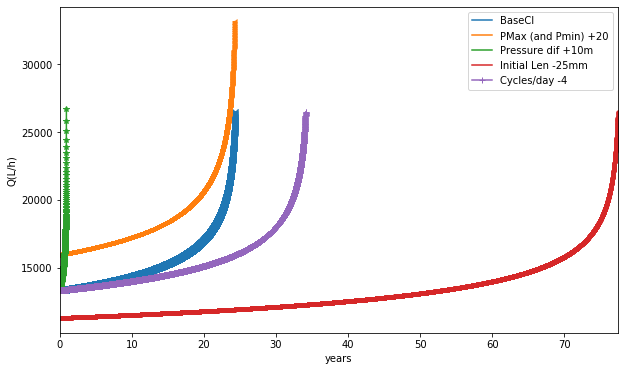

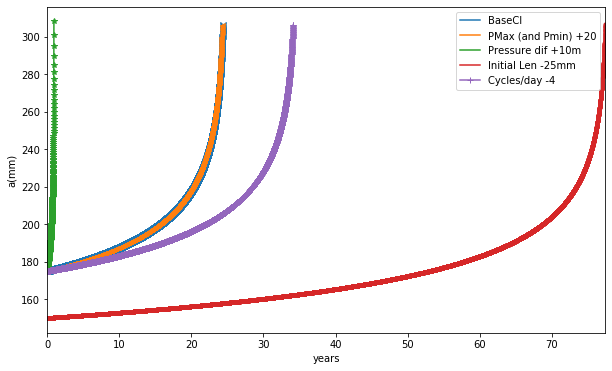

In [28]:

df = pd.DataFrame(curveQValsCI, columns=['cycles','Flow'])
df['Flow']=df['Flow']*3600000
df['years']=df['cycles']/(365)
ax = df.plot(x='years',y='Flow', label='BaseCI', marker='x',figsize=(10,6))

df2 = pd.DataFrame(curveQValsCI50MAx, columns=['cycles','Flow'])
df2['Flow']=df2['Flow']*3600000
df2['years']=df2['cycles']/(365)
df2.plot(x='years',y='Flow', label='PMax (and Pmin) +20',ax=ax, marker='3')

df3 = pd.DataFrame(curveQValsCI70100, columns=['cycles','Flow'])
df3['Flow']=df3['Flow']*3600000
df3['years']=df3['cycles']/(365)
df3.plot(x='years',y='Flow', label='Pressure dif +10m',ax=ax, marker='*')


df4 = pd.DataFrame(curveQValsCI1cmlo, columns=['cycles','Flow'])
df4['Flow']=df4['Flow']*3600000
df4['years']=df4['cycles']/(365)
df4.plot(x='years',y='Flow', label='Initial Len -25mm',ax=ax, marker='.')

df5 = pd.DataFrame(curveQValsCI1c, columns=['cycles','Flow'])
df5['Flow']=df5['Flow']*3600000
df5['years']=df5['cycles']/(365)
df5.plot(x='years',y='Flow', label='Cycles/day -4',ax=ax, marker='+')
ax.set_ylabel('Q(L/h)')

ax.get_figure().savefig('Maps_Graph/CrackGrowth/'+ 'FlowCIPaper' + '.png', dpi=200)

volLossCI = (df['Flow']* 24).sum()
volLoss50Max = (df2['Flow']* 24).sum()
volLoss70100 = (df3['Flow']* 24).sum()
volLoss1cmlo = (df4['Flow']* 24).sum()
volLossCI1c = (df5['Flow']* 24).sum()


df = pd.DataFrame(curveValsCI, columns=['cycles','Flow'])
df['Flow']=df['Flow']*1000
df['years']=df['cycles']/(365)
ax = df.plot(x='years',y='Flow', label='BaseCI', marker='x',figsize=(10,6))

df2 = pd.DataFrame(curveValsCI50MAx, columns=['cycles','Flow'])
df2['years']=df2['cycles']/(365)
df2['Flow']=df2['Flow']*1000
df2.plot(x='years',y='Flow', label='PMax (and Pmin) +20',ax=ax, marker='3')

df3 = pd.DataFrame(curveValsCI70100, columns=['cycles','Flow'])
df3['years']=df3['cycles']/(365)
df3['Flow']=df3['Flow']*1000
df3.plot(x='years',y='Flow', label='Pressure dif +10m',ax=ax, marker='*')


df4 = pd.DataFrame(curveValsCI1cmlo, columns=['cycles','Flow'])
df4['years']=df4['cycles']/(365)
df4['Flow']=df4['Flow']*1000
df4.plot(x='years',y='Flow', label='Initial Len -25mm',ax=ax, marker='.')

df5 = pd.DataFrame(curveValsCI1c, columns=['cycles','Flow'])
df5['years']=df5['cycles']/(365)
df5['Flow']=df5['Flow']*1000
df5.plot(x='years',y='Flow', label='Cycles/day -4',ax=ax, marker='+')
ax.set_ylabel('a(mm)')

ax.get_figure().savefig('Maps_Graph/CrackGrowth/'+ 'LenghtCIPaper' + '.png', dpi=200)


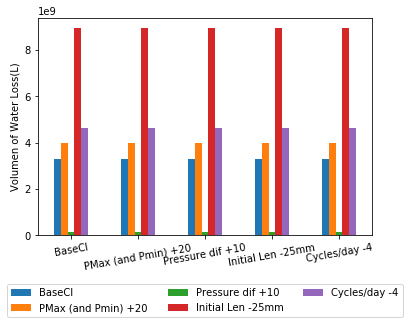

In [43]:
dfVolLoss = pd.DataFrame({'BaseCI': volLossCI ,
'PMax (and Pmin) +20':volLoss50Max ,
'Pressure dif +10': volLoss70100,
'Initial Len -25mm': volLoss1cmlo ,
'Cycles/day -4':volLossCI1c
}, index=['BaseCI','PMax (and Pmin) +20' ,'Pressure dif +10','Initial Len -25mm' ,'Cycles/day -4'])

axvloss = dfVolLoss.plot.bar(rot=10)
axvloss.set_ylabel('Volumen of Water Loss(L)')

axvloss.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)

axvloss.get_figure().savefig('Maps_Graph/CrackGrowth/'+ 'VolumenWaterLoss' + '.png', dpi=200)



,BaseCI,PMax (and Pmin) +20,Pressure dif +10,Initial Len -25mm,Cycles/day -4
BaseCI,3.308588e+09,3.988808e+09,1.271642e+08,8.936911e+09,4.631500e+09
PMax (and Pmin) +20,3.308588e+09,3.988808e+09,1.271642e+08,8.936911e+09,4.631500e+09
Pressure dif +10,3.308588e+09,3.988808e+09,1.271642e+08,8.936911e+09,4.631500e+09
Initial Len -25mm,3.308588e+09,3.988808e+09,1.271642e+08,8.936911e+09,4.631500e+09
Cycles/day -4,3.308588e+09,3.988808e+09,1.271642e+08,8.936911e+09,4.631500e+09


In [27]:
pvcVals

,Material,Dint (mm),Dext (mm),Thickness (mm),Elastic modulus (Gpa),Cparis,mParis,Dint (m),Thickness (m),Elastic modulus (Pa)
0,PVC,50.0,60,5.0,2.25,0.000199,2.724,0.500,0.050,2.250000e+09
1,PVC,107.8,122,7.1,3.00,0.000577,3.557,1.078,0.071,3.000000e+09
2,PVC,460.2,507,23.4,3.50,0.000955,4.390,4.602,0.234,3.500000e+09


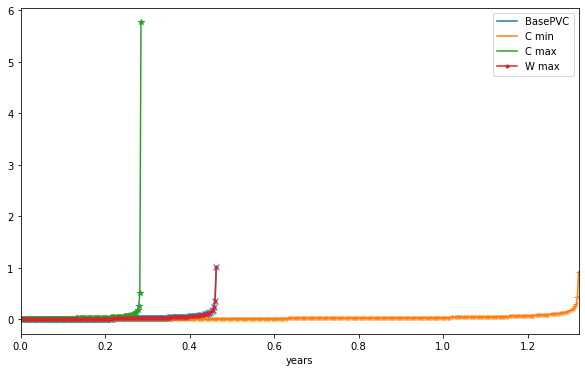

In [48]:
df = pd.DataFrame(curveVals, columns=['cycles','Lenght'])
df['months']=df['cycles']/(365)
ax = df.plot(x='months',y='Lenght', label='BasePVC', marker='x',figsize=(10,6))

df2 = pd.DataFrame(curveValsCm, columns=['cycles','Lenght'])
df2['years']=df2['cycles']/(365)
df2.plot(x='years',y='Lenght', label='C min',ax=ax, marker='3')

df3 = pd.DataFrame(curveValsCma, columns=['cycles','Lenght'])
df3['years']=df3['cycles']/(365)
df3.plot(x='years',y='Lenght', label='C max',ax=ax, marker='*')


df7 = pd.DataFrame(curveValsWmax, columns=['cycles','Lenght'])
df7['years']=df7['cycles']/(365)
df7.plot(x='years',y='Lenght', label='W max',ax=ax, marker='.')

In [107]:
mV= attributes.loc[material].reset_index()

In [108]:
mV

,Material,Dint (mm),Dext (mm),Thickness (mm),Elastic modulus (Gpa),Cparis,mParis,Dint (m),Thickness (m),Elastic modulus (Pa)
0,DI,80.0,96,8.0,165.0,3.510000e-19,3.50,0.8,0.080,1.650000e+11
1,DI,150.0,177,13.5,170.0,7.200000e-12,6.45,1.5,0.135,1.700000e+11
2,DI,750.0,826,38.0,172.0,1.440000e-11,9.40,7.5,0.380,1.720000e+11


In [ ]:

    
Timef, critical, curveVals40Max, curveQVals40Max= createCurveUntilDetectable(0.001,
                                                                   0.65,
                                                                   mV.loc[1,'Elastic modulus (Pa)'],
                                                                   mV.loc[1,'Cparis'],
                                                                   mV.loc[1,'mParis'],
                                                                   mV.loc[1,'Thickness (m)'],
                                                                   mV.loc[1,'Dint (m)'],
                                                                   0.01,
                                                                   1,
                                                                   40,
                                                                   20)


Text(0, 0.5, 'Q(m3/s)')

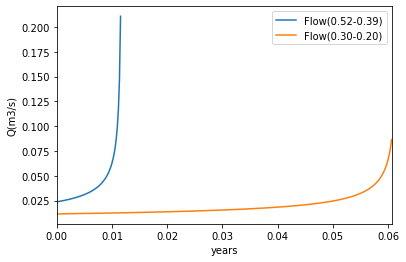

In [15]:
#graph
vals, valsW = createCurve(Dint,E,t,lo,Cparis,nCicles,0.52,0.39,False)
df = pd.DataFrame(vals, columns=['cycles','Flow(0.52-0.39)'])
df['years']=df['cycles']/(365*N)
ax = df.plot(x='years',y='Flow(0.52-0.39)')

vals2, valsW = createCurve(Dint,E,t,lo,Cparis,nCicles,0.30,0.20,False)

df2 = pd.DataFrame(vals2, columns=['cycles','Flow(0.30-0.20)'])
df2['years']=df2['cycles']/(365*N)
df2.plot(x='years',y='Flow(0.30-0.20)', ax=ax)


ax.set_ylabel('Q(m3/s)')



Text(0, 0.5, 'a(m)')

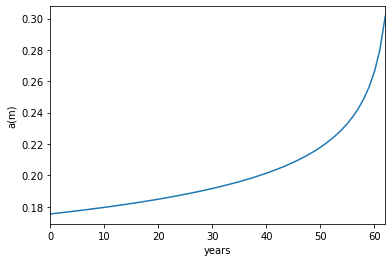

In [31]:
#graph
df = pd.DataFrame(curveVals, columns=['cycles','Crack lenght'])
df['years']=df['cycles']/(365*N)
ax = df.plot(x='years',y='Crack lenght', legend=False)
ax.set_ylabel('a(m)')
    

## OLD---------------------------------------------------------------------------------

In [14]:
#Uses Pmax for the flow (i.e. minimum night flow)
def createCurve(Dint,E,t,lo,Cparis,nCicles,Pmax,Pmin,meters):

    #initialization 
    li = lo
    curveVals = []
    curveQVals = []
    Timef = 0
    D= (Dint + (Dint + t))/2
    
    
    #gets the pressure and pressure difference in the necessary units for TADA and FAVAD eq
    if meters:
        deltaP= convertmToMPa(Pmax-Pmin)
        h= Pmax
    else:
        deltaP = Pmax-Pmin
        h=convertMPaTom(Pmax)
    

    #Euler
    while li < lcritical:

        #Paris Law------------------------------------------------------------------
        
        #calculation of the geometric factor (from Tada)
        lam = li/(D*t/2)**0.5
        if lam <= 1:
            Y = (1+1.25* lam**2)**0.5   
        elif lam <= 5:
            Y = 0.6 + (0.9 * lam)
            
        
        #calculation of delta K
        deltaK = deltaP * D / (2*t) * Y * (math.pi * li)**0.5

        #Final lenght of the crack
        lf = (Cparis * deltaK**m )* nCicles + li

        curveVals.append([Timef,lf])

        # FAVAD--- from paper 012---------------------------------------------------
        leakArea = lf*widthC
        
        mFAVAD = getMLongFAVAD(lf,Dint,E,t)
        
        Q = Cd*((2*9.81)**0.5)*(leakArea*(h**0.5)+mFAVAD*(h**1.5))

        curveQVals.append([Timef,Q])                       

        #print(Timef,"-",li,"-",lam,"-",lf,"-",mFAVAD,"-",Y,"-",deltaK,"-",Q)
        
        li = lf
        Timef += deltaT
        
        
    return curveQVals, curveVals


In [7]:
materials = attributes.index.unique()
labels = ['Very low', 'Low', 'High', 'Very high', 'Typical']
indexValues = [0,1,3,4,2]

for material in []:
    
    mV= attributes.loc[material].reset_index()
    
    #FAVAD constants (min, typical, max, name)
    widths = [0.00001, 0.001, 0.05, "widthC"]# m  (min from paper 012)
    Cds = [0.5, 0.65, 0.8, "Cd"] #dimensionless (from paper 007)

    EModulus = [mV.loc[0,'Elastic modulus (Pa)'], mV.loc[1,'Elastic modulus (Pa)'], mV.loc[2,'Elastic modulus (Pa)'], "E"] #Pa (from excel material properties)
    CsParis = [mV.loc[0,'Cparis'], mV.loc[1,'Cparis'], mV.loc[2,'Cparis'], "Cparis"] #((m/c)/(MPa*sqrt(m))^m (aprox from equation and Book C001)
    msParis = [mV.loc[0,'mParis'], mV.loc[1,'mParis'], mV.loc[2,'mParis'], "mParis"] # (aprox from equation and Book C001)

    thicks = [mV.loc[0,'Thickness (m)'], mV.loc[1,'Thickness (m)'], mV.loc[2,'Thickness (m)'], "thickness"] #m (from paper 012, 001, 98)
    Dsint = [mV.loc[0,'Dint (m)'], mV.loc[1,'Dint (m)'], mV.loc[2,'Dint (m)'], "Dint"]#m (aprox from data wPipesGISNfailures[['NOM_DIA_MM']])

    crackLenghs= [0.020, 0.1, 0.300, "cLenght"] #m (assumtion)

    Ncycles= [1, 2, 14, "N"] #cycle per day (assumption)
    PressuresMin = [0, 20 , 100, "PMin"] #mca
    PressuresMax = [100, 150 ,400, "PMax"] #mca

    #list of variable variables
    iterables = [widths,Cds,EModulus,CsParis,msParis,thicks,Dsint,crackLenghs,Ncycles,PressuresMax,PressuresMin]

    getSpiderGraphMaterial(iterables,material)
    
    
    

def getSpiderGraphMaterial(va,material):
    
    finVals = []
    cVals = getCurrentValsDict(va[0][1],va[1][1],va[2][1],va[3][1],va[4][1],va[5][1],
                               va[6][1],va[7][1],va[8][1],va[9][1],va[10][1])
    for v in va:
    
        print(material," ",v)
        vMin, vTypical, vMax, name = v[0], v[1], v[2] ,v[3]

        int1 = vMin + (vTypical - vMin)/2
        int2 = vTypical + (vMax - vTypical)/2

        for val, i in zip([vMin, int1, int2, vMax, vTypical], indexValues):

            cVals[name] = val
            N = cVals["N"]

            timeDetectable, critical = createCurveUntilDetectable(cVals["widthC"],cVals["Cd"],cVals["E"],cVals["Cparis"]
                                                        ,cVals["mParis"],cVals["thickness"],cVals["Dint"],
                                                        cVals["cLenght"],N,cVals["PMax"],cVals["PMin"])


            finVals.append([val, name, timeDetectable, N, critical, i])

    results = pd.DataFrame(finVals, columns=['Value', 'Variable', 'CriticalCycles', 'N','CriticalLength','index'])
    results['Time (year)'] = results['CriticalCycles']/(365*results['N'])
    results.set_index('Variable',inplace= True)


    fig, ax = plt.subplots(1, figsize=(10, 8))
    for var in results.index.unique():

        resVar = results.loc[var]
        ax.plot(resVar['index'],resVar['Time (year)'],label=var,marker='+',markersize=12)


    ax.set_ylim(0,100)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=5)
    
    ax.get_figure().savefig('Maps_Graph/CrackGrowth/'+ material+ 'Sensivility' +'.png', dpi=100,      
                                bbox_inches='tight')
    


